In [1]:
import jcopdl, luwiji
jcopdl.__version__, luwiji.__version__

('1.1.9', '1.2.1')

In [2]:
import numpy as np
import matplotlib.pyplot as plt 

In [3]:
import torch
from torch import nn, optim
from jcopdl.callback import Callback, set_config

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")
device

device(type='cpu')

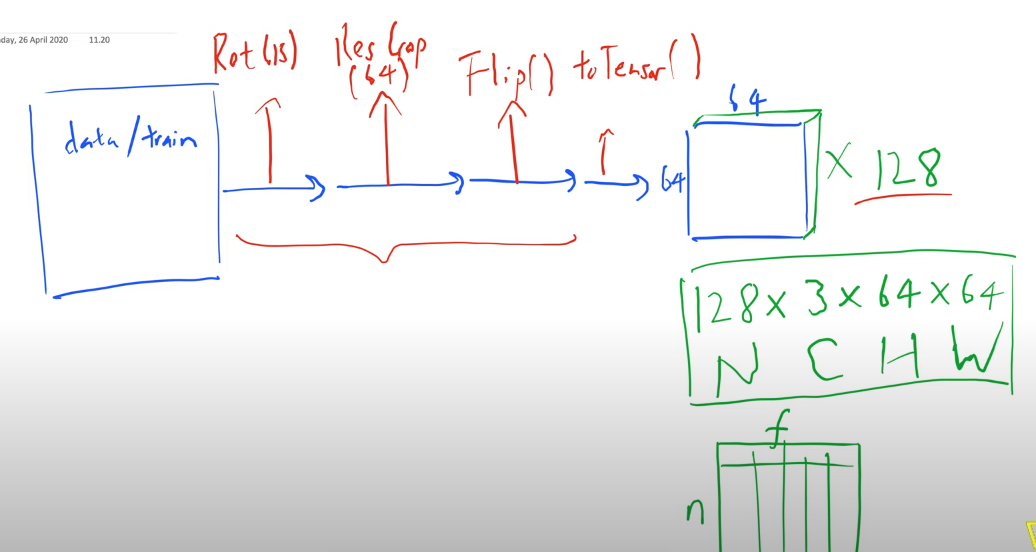

# Dataset & Dataloader

In [4]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [5]:
bs = 128
# crop_size = 224 # Idealnya 224
crop_size = 64

train_transform = transforms.Compose([
    transforms.RandomRotation(15),
    transforms.RandomResizedCrop(crop_size, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()
])

test_transform = transforms.Compose([
    transforms.Resize(70),
    transforms.CenterCrop(crop_size),
    transforms.ToTensor()
])

train_set = datasets.ImageFolder("data/train/", transform=train_transform)
trainloader = DataLoader(train_set, batch_size=bs, shuffle=True, num_workers=1)

test_set = datasets.ImageFolder("data/test/", transform=test_transform)
testloader = DataLoader(test_set, batch_size=bs, shuffle=True)

In [11]:
pip show torch

Note: you may need to restart the kernel to use updated packages.Name: torch
Version: 2.0.0
Summary: Tensors and Dynamic neural networks in Python with strong GPU acceleration
Home-page: https://pytorch.org/
Author: PyTorch Team
Author-email: packages@pytorch.org
License: BSD-3
Location: e:\anaconda3\envs\jcopdl\lib\site-packages
Requires: filelock, jinja2, networkx, sympy, typing-extensions
Required-by: jcopdl, torchtext, torchvision



In [6]:
feature, target = next(iter(trainloader))
feature.shape

torch.Size([128, 3, 64, 64])

In [7]:
label2cat = train_set.classes
label2cat

['invasive', 'noninvasive']

# Arsitektur & Config

In [13]:
# catatan contoh flatten: 64 adalah channel 4x4 adalah pixel
# linear (1024, 256) fully connected layer atau dense layer

In [8]:
# Kalau manual tanpa block

# nn.Conv2d(3, 8, 3, 1, 1),
# nn.ReLU(),
# nn.MaxPool2d(2, 2)

In [9]:
nn.Conv2d(3, 8, 3, 1, 1)

Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))

- 3: Argumen pertama (in_channels) adalah jumlah saluran (channels) pada input. Dalam konteks ini, input diharapkan memiliki 3 saluran warna (R, G, B) pada gambar, sehingga in_channels disetel ke 3.

- 8: Argumen kedua (out_channels) adalah jumlah saluran (channels) pada output. Ini menentukan berapa banyak filter (kernel) yang akan digunakan dalam lapisan konvolusi dan juga akan menentukan jumlah saluran pada output. Dalam kasus ini, lapisan konvolusi akan menghasilkan 8 saluran pada output.

- 3: Argumen ketiga (kernel_size) adalah ukuran kernel konvolusi yang akan digunakan. Dalam contoh ini, ukuran kernel adalah 3x3. Ini berarti setiap filter dalam lapisan konvolusi akan memiliki ukuran 3x3.

- 1: Argumen keempat (stride) adalah langkah (stride) yang digunakan saat melakukan konvolusi. Ini menentukan sejauh berapa langkah kernel bergerak pada setiap iterasi saat melakukan konvolusi. Dalam kasus ini, langkahnya adalah 1, yang berarti kernel bergerak satu langkah pada setiap iterasi.

- 1: Argumen kelima (padding) adalah jumlah padding yang ditambahkan ke sekitar input. Padding digunakan untuk mempertahankan dimensi spatialis input dan memungkinkan kernel untuk memproses piksel di tepi gambar dengan benar. Jika padding=1, maka padding 1 piksel ditambahkan di sekitar input.

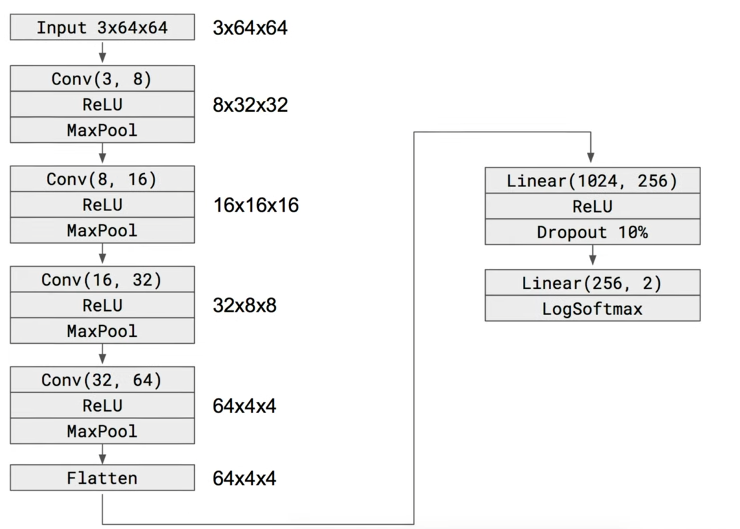

In [10]:
from jcopdl.layers import conv_block, linear_block

In [11]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
            conv_block(3, 8),
            conv_block(8, 16),
            conv_block(16, 32),
            conv_block(32, 64),
            nn.Flatten()
        )
        
        self.fc = nn.Sequential(
            linear_block(1024, 256, dropout=0.1),
            linear_block(256, 2, activation="lsoftmax"),
        )
        
        
    def forward(self, x):
        x = self.conv(x)
        x = self.fc(x)
        return x

In [12]:
config = set_config({
    "batch_size" : bs,
    "crop_size" : crop_size
})

# Training Preparation -> MCOC

In [13]:
model = CNN()
criterion = nn.NLLLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001)
callback = Callback(model, config, outdir="model")

In [14]:
model.parameters()

<generator object Module.parameters at 0x0000027233652820>

# Training

In [15]:
from tqdm.auto import tqdm

def loop_fn(mode, dataset, dataloader, model, criterion, optimizer):
    if mode == "train":
        model.train()
    elif mode == "test":
        model.eval()
    cost = correct = 0
    for feature, target in tqdm(dataloader, desc=mode.title()):
        feature, target = feature, target
        output = model(feature)
        loss = criterion(output, target)
        
        if mode == "train":
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        
        cost += loss.item() * feature.shape[0]
        correct += (output.argmax(1) == target).sum().item()
    cost = cost / len(dataset)
    acc = correct / len(dataset)
    return cost, acc

In [16]:
import time

Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch     1
Train_cost  = 0.6950 | Test_cost  = 0.6908 | Train_score = 0.5070 | Test_score = 0.7575 |
Time for epoch 1: 10.07 seconds


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:05<?, ?it/s]


Epoch     2
Train_cost  = 0.6870 | Test_cost  = 0.6734 | Train_score = 0.5590 | Test_score = 0.5050 |
Time for epoch 2: 10.18 seconds
==> EarlyStop patience =  1 | Best test_score: 0.7575


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:05<?, ?it/s]


Epoch     3
Train_cost  = 0.6661 | Test_cost  = 0.6403 | Train_score = 0.6450 | Test_score = 0.5675 |
Time for epoch 3: 10.26 seconds
==> EarlyStop patience =  2 | Best test_score: 0.7575


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:05<?, ?it/s]


Epoch     4
Train_cost  = 0.6206 | Test_cost  = 0.6033 | Train_score = 0.6680 | Test_score = 0.6325 |
Time for epoch 4: 10.46 seconds
==> EarlyStop patience =  3 | Best test_score: 0.7575


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:05<?, ?it/s]


Epoch     5
Train_cost  = 0.5600 | Test_cost  = 0.5157 | Train_score = 0.7070 | Test_score = 0.7275 |
Time for epoch 5: 10.03 seconds
==> EarlyStop patience =  4 | Best test_score: 0.7575


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:05<?, ?it/s]


Epoch     6
Train_cost  = 0.5257 | Test_cost  = 0.4883 | Train_score = 0.7340 | Test_score = 0.7800 |
Time for epoch 6: 10.15 seconds


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:05<?, ?it/s]


Epoch     7
Train_cost  = 0.4992 | Test_cost  = 0.4536 | Train_score = 0.7470 | Test_score = 0.7875 |
Time for epoch 7: 10.13 seconds


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch     8
Train_cost  = 0.4937 | Test_cost  = 0.4866 | Train_score = 0.7630 | Test_score = 0.7475 |
Time for epoch 8: 5.11 seconds
==> EarlyStop patience =  1 | Best test_score: 0.7875


Train:   0%|          | 0/8 [00:05<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch     9
Train_cost  = 0.4450 | Test_cost  = 0.4358 | Train_score = 0.8040 | Test_score = 0.7925 |
Time for epoch 9: 10.15 seconds


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    10
Train_cost  = 0.4182 | Test_cost  = 0.3871 | Train_score = 0.8150 | Test_score = 0.8325 |
Time for epoch 10: 5.14 seconds


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:15<?, ?it/s]


Epoch    11
Train_cost  = 0.4042 | Test_cost  = 0.4335 | Train_score = 0.8130 | Test_score = 0.8050 |
Time for epoch 11: 20.37 seconds
==> EarlyStop patience =  1 | Best test_score: 0.8325


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    12
Train_cost  = 0.4036 | Test_cost  = 0.3761 | Train_score = 0.8180 | Test_score = 0.8375 |
Time for epoch 12: 10.20 seconds


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    13
Train_cost  = 0.4213 | Test_cost  = 0.3996 | Train_score = 0.8150 | Test_score = 0.8400 |
Time for epoch 13: 10.09 seconds


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:05<?, ?it/s]


Epoch    14
Train_cost  = 0.4040 | Test_cost  = 0.3861 | Train_score = 0.8200 | Test_score = 0.8325 |
Time for epoch 14: 10.18 seconds
==> EarlyStop patience =  1 | Best test_score: 0.8400


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:05<?, ?it/s]


Epoch    15
Train_cost  = 0.3617 | Test_cost  = 0.3533 | Train_score = 0.8440 | Test_score = 0.8425 |
Time for epoch 15: 10.11 seconds


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    16
Train_cost  = 0.3674 | Test_cost  = 0.3522 | Train_score = 0.8320 | Test_score = 0.8400 |
Time for epoch 16: 5.21 seconds
==> EarlyStop patience =  1 | Best test_score: 0.8425


Train:   0%|          | 0/8 [00:05<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    17
Train_cost  = 0.3648 | Test_cost  = 0.4569 | Train_score = 0.8370 | Test_score = 0.7850 |
Time for epoch 17: 10.04 seconds
==> EarlyStop patience =  2 | Best test_score: 0.8425


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    18
Train_cost  = 0.3580 | Test_cost  = 0.3561 | Train_score = 0.8420 | Test_score = 0.8400 |
Time for epoch 18: 5.02 seconds
==> EarlyStop patience =  3 | Best test_score: 0.8425


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    19
Train_cost  = 0.3327 | Test_cost  = 0.3346 | Train_score = 0.8500 | Test_score = 0.8550 |
Time for epoch 19: 5.24 seconds


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    20
Train_cost  = 0.3255 | Test_cost  = 0.3257 | Train_score = 0.8550 | Test_score = 0.8600 |


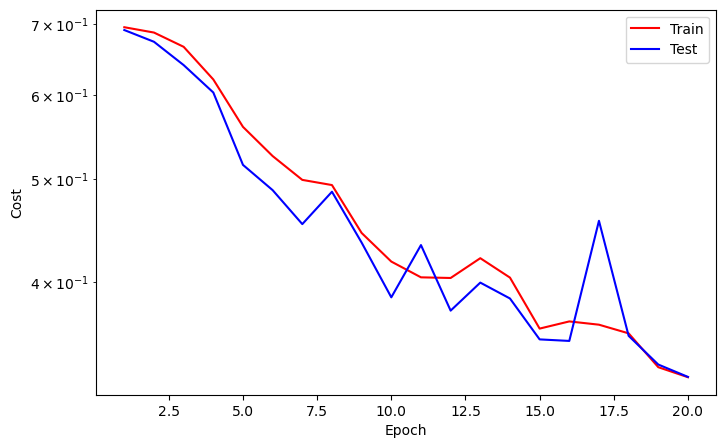

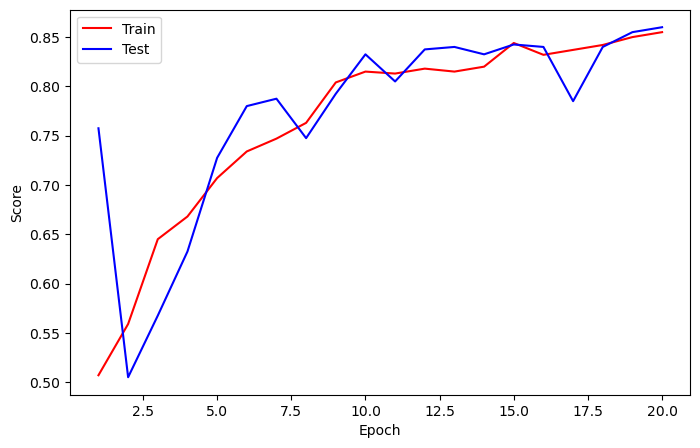

Time for epoch 20: 25.95 seconds


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    21
Train_cost  = 0.3300 | Test_cost  = 0.3396 | Train_score = 0.8550 | Test_score = 0.8475 |
Time for epoch 21: 10.35 seconds
==> EarlyStop patience =  1 | Best test_score: 0.8600


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    22
Train_cost  = 0.3538 | Test_cost  = 0.3611 | Train_score = 0.8490 | Test_score = 0.8425 |
Time for epoch 22: 10.34 seconds
==> EarlyStop patience =  2 | Best test_score: 0.8600


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    23
Train_cost  = 0.3470 | Test_cost  = 0.3815 | Train_score = 0.8570 | Test_score = 0.8175 |
Time for epoch 23: 10.22 seconds
==> EarlyStop patience =  3 | Best test_score: 0.8600


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    24
Train_cost  = 0.3779 | Test_cost  = 0.3350 | Train_score = 0.8430 | Test_score = 0.8525 |
Time for epoch 24: 5.17 seconds
==> EarlyStop patience =  4 | Best test_score: 0.8600


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    25
Train_cost  = 0.3359 | Test_cost  = 0.3311 | Train_score = 0.8560 | Test_score = 0.8525 |
Time for epoch 25: 9.88 seconds
==> EarlyStop patience =  5 | Best test_score: 0.8600
==> Execute Early Stopping at epoch: 25 | Best test_score: 0.8600
==> Best model is saved at model


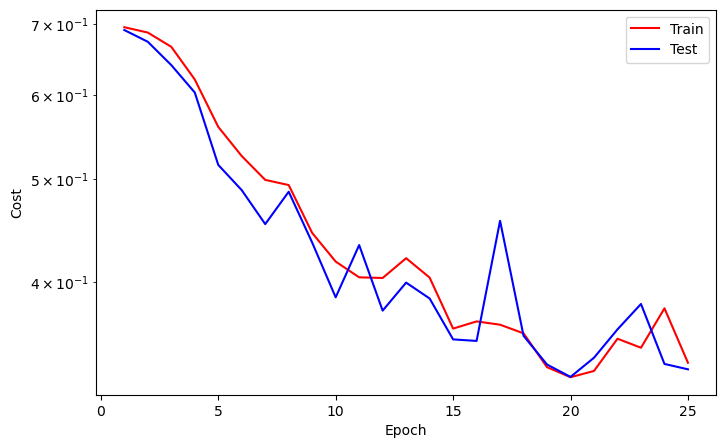

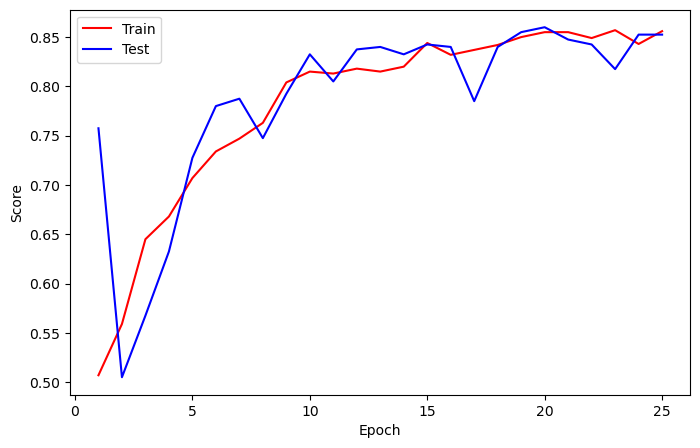

In [17]:
epoch = 0
while True:
    start_time = time.time()
    train_cost, train_score = loop_fn("train", train_set, trainloader, model, criterion, optimizer)
    with torch.no_grad():
        test_cost, test_score = loop_fn("test", test_set, testloader, model, criterion, optimizer)
    
    # Logging
    callback.log(train_cost, test_cost, train_score, test_score)

    # Checkpoint
    callback.save_checkpoint()
        
    # Runtime Plotting
    callback.cost_runtime_plotting()
    callback.score_runtime_plotting()
    
    end_time = time.time()
    epoch_time = end_time - start_time
    epoch += 1
    print(f'Time for epoch {epoch}: {epoch_time:.2f} seconds')
    start_time = end_time
    
    # Early Stopping
    if callback.early_stopping(model, monitor="test_score"):
        callback.plot_cost()
        callback.plot_score()
        break

In [ ]:
epoch = 0
while True:
    start_time = time.time()
    train_cost, train_score = loop_fn("train", train_set, trainloader, model, criterion, optimizer)
    with torch.no_grad():
        test_cost, test_score = loop_fn("test", test_set, testloader, model, criterion, optimizer)
    
    # Logging
    callback.log(train_cost, test_cost, train_score, test_score)

    # Checkpoint
    callback.save_checkpoint()
        
    # Runtime Plotting
    callback.cost_runtime_plotting()
    callback.score_runtime_plotting()
    
    # Early Stopping
    if callback.early_stopping(model, monitor="test_score"):
        callback.plot_cost()
        callback.plot_score()
    
    end_time = time.time()
    epoch_time = end_time - start_time
    epoch += 1
    print(f'Time for epoch {epoch}: {epoch_time:.2f} seconds')
    start_time = end_time
    
    if callback.early_stopping(model):
        break

Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch     1
Train_cost  = 0.6936 | Test_cost  = 0.6907 | Train_score = 0.4920 | Test_score = 0.5225 |
Time for epoch 1: 5.41 seconds
==> EarlyStop patience =  1 | Best test_score: 0.5225


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch     3
Train_cost  = 0.6917 | Test_cost  = 0.6845 | Train_score = 0.4890 | Test_score = 0.5000 |
==> EarlyStop patience =  2 | Best test_score: 0.5225
Time for epoch 2: 5.42 seconds
==> EarlyStop patience =  3 | Best test_score: 0.5225


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch     5
Train_cost  = 0.6720 | Test_cost  = 0.6330 | Train_score = 0.5570 | Test_score = 0.8150 |
Time for epoch 3: 5.16 seconds
==> EarlyStop patience =  1 | Best test_score: 0.8150


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch     7
Train_cost  = 0.5922 | Test_cost  = 0.5012 | Train_score = 0.7490 | Test_score = 0.7625 |
==> EarlyStop patience =  2 | Best test_score: 0.8150
Time for epoch 4: 5.25 seconds
==> EarlyStop patience =  3 | Best test_score: 0.8150


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch     1
Train_cost  = 0.6927 | Test_cost  = 0.6861 | Train_score = 0.5010 | Test_score = 0.6375 |
Time for epoch 1: 10.12 seconds


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:05<?, ?it/s]


Epoch     2
Train_cost  = 0.6777 | Test_cost  = 0.6578 | Train_score = 0.6290 | Test_score = 0.6350 |
==> EarlyStop patience =  1 | Best test_score: 0.6375
Time for epoch 2: 10.08 seconds


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:05<?, ?it/s]


Epoch     3
Train_cost  = 0.6267 | Test_cost  = 0.5963 | Train_score = 0.6660 | Test_score = 0.6725 |
Time for epoch 3: 10.24 seconds


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch     4
Train_cost  = 0.5755 | Test_cost  = 0.5513 | Train_score = 0.6940 | Test_score = 0.7400 |
Time for epoch 4: 9.95 seconds


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:05<?, ?it/s]


Epoch     5
Train_cost  = 0.5437 | Test_cost  = 0.5253 | Train_score = 0.7310 | Test_score = 0.7475 |
Time for epoch 5: 10.26 seconds


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:05<?, ?it/s]


Epoch     6
Train_cost  = 0.5237 | Test_cost  = 0.4905 | Train_score = 0.7340 | Test_score = 0.7800 |
Time for epoch 6: 10.21 seconds


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:05<?, ?it/s]


Epoch     7
Train_cost  = 0.4868 | Test_cost  = 0.4858 | Train_score = 0.7750 | Test_score = 0.7800 |
==> EarlyStop patience =  1 | Best test_score: 0.7800
Time for epoch 7: 10.18 seconds


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch     8
Train_cost  = 0.4776 | Test_cost  = 0.4844 | Train_score = 0.7660 | Test_score = 0.7725 |
==> EarlyStop patience =  2 | Best test_score: 0.7800
Time for epoch 8: 5.32 seconds


Train:   0%|          | 0/8 [00:05<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch     9
Train_cost  = 0.4578 | Test_cost  = 0.4425 | Train_score = 0.7810 | Test_score = 0.7975 |
Time for epoch 9: 10.14 seconds


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    10
Train_cost  = 0.4401 | Test_cost  = 0.4232 | Train_score = 0.7880 | Test_score = 0.8125 |
Time for epoch 10: 5.47 seconds


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:05<?, ?it/s]


Epoch    11
Train_cost  = 0.4236 | Test_cost  = 0.4359 | Train_score = 0.8120 | Test_score = 0.8050 |
==> EarlyStop patience =  1 | Best test_score: 0.8125
Time for epoch 11: 10.42 seconds


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:15<?, ?it/s]


Epoch    12
Train_cost  = 0.4218 | Test_cost  = 0.4163 | Train_score = 0.8120 | Test_score = 0.8100 |
==> EarlyStop patience =  2 | Best test_score: 0.8125
Time for epoch 12: 20.29 seconds


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    13
Train_cost  = 0.4146 | Test_cost  = 0.3921 | Train_score = 0.8100 | Test_score = 0.8300 |
Time for epoch 13: 10.17 seconds


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    14
Train_cost  = 0.4243 | Test_cost  = 0.3659 | Train_score = 0.8090 | Test_score = 0.8500 |
Time for epoch 14: 10.28 seconds


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    15
Train_cost  = 0.4270 | Test_cost  = 0.4031 | Train_score = 0.7980 | Test_score = 0.8225 |
==> EarlyStop patience =  1 | Best test_score: 0.8500
Time for epoch 15: 10.24 seconds


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    16
Train_cost  = 0.4142 | Test_cost  = 0.3658 | Train_score = 0.8240 | Test_score = 0.8475 |
==> EarlyStop patience =  2 | Best test_score: 0.8500
Time for epoch 16: 5.09 seconds


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    17
Train_cost  = 0.4002 | Test_cost  = 0.3681 | Train_score = 0.8190 | Test_score = 0.8475 |
==> EarlyStop patience =  3 | Best test_score: 0.8500
Time for epoch 17: 5.98 seconds


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    18
Train_cost  = 0.3956 | Test_cost  = 0.4101 | Train_score = 0.8170 | Test_score = 0.8325 |
==> EarlyStop patience =  4 | Best test_score: 0.8500
Time for epoch 18: 5.14 seconds


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    19
Train_cost  = 0.4055 | Test_cost  = 0.3726 | Train_score = 0.8120 | Test_score = 0.8500 |
==> EarlyStop patience =  5 | Best test_score: 0.8500
==> Execute Early Stopping at epoch: 19 | Best test_score: 0.8500
==> Best model is saved at model


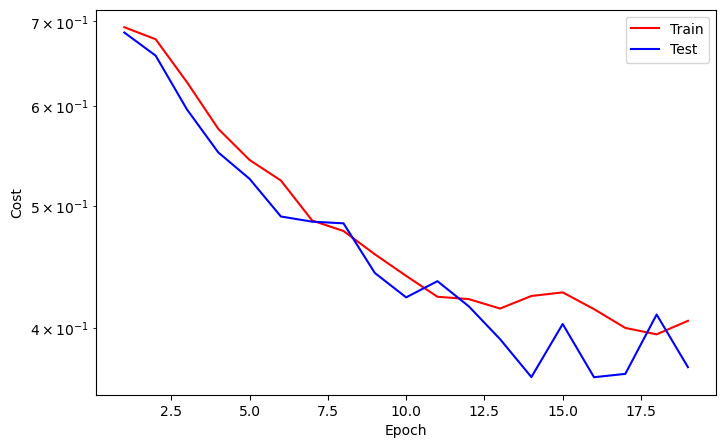

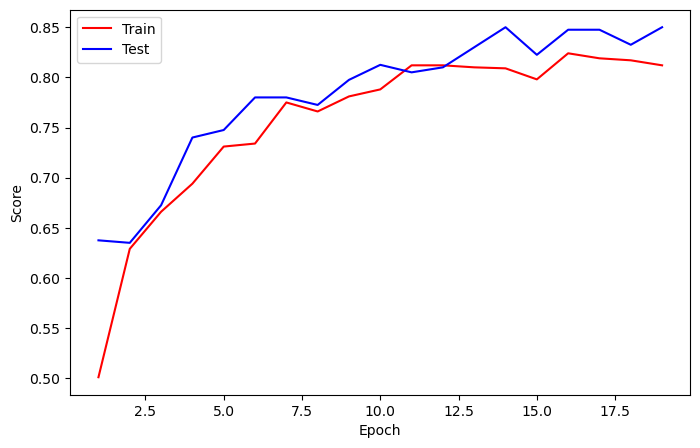

In [17]:
epoch = 0
while True:
    start_time = time.time()
    train_cost, train_score = loop_fn("train", train_set, trainloader, model, criterion, optimizer)
    with torch.no_grad():
        test_cost, test_score = loop_fn("test", test_set, testloader, model, criterion, optimizer)
    
    # Logging
    callback.log(train_cost, test_cost, train_score, test_score)

    # Checkpoint
    callback.save_checkpoint()
        
    # Runtime Plotting
    callback.cost_runtime_plotting()
    callback.score_runtime_plotting()
    
    # Early Stopping
    if callback.early_stopping(model, monitor="test_score"):
        callback.plot_cost()
        callback.plot_score()
        break
    
    end_time = time.time()
    epoch_time = end_time - start_time
    epoch += 1
    print(f'Time for epoch {epoch}: {epoch_time:.2f} seconds')
    start_time = end_time
    
    if callback.early_stopping(model, monitor="test_score"):
        break
#     if callback.early_stopping:
#         break    

# Predict

In [25]:
feature, target = next(iter(testloader))
feature

tensor([[[[0.6078, 0.5137, 0.5137,  ..., 0.6275, 0.4941, 0.5373],
          [0.6000, 0.4471, 0.4745,  ..., 0.4627, 0.3961, 0.5216],
          [0.4706, 0.3569, 0.3098,  ..., 0.4863, 0.4118, 0.4902],
          ...,
          [0.2353, 0.2471, 0.2118,  ..., 0.3216, 0.3569, 0.3529],
          [0.2745, 0.2902, 0.2471,  ..., 0.3686, 0.3922, 0.4078],
          [0.3098, 0.3020, 0.2784,  ..., 0.3765, 0.3765, 0.3725]],

         [[0.6314, 0.5255, 0.5333,  ..., 0.6667, 0.5216, 0.5529],
          [0.6353, 0.4667, 0.4980,  ..., 0.4824, 0.4078, 0.5333],
          [0.5176, 0.3882, 0.3255,  ..., 0.4863, 0.4157, 0.5020],
          ...,
          [0.2196, 0.2235, 0.1804,  ..., 0.3373, 0.3608, 0.3647],
          [0.2549, 0.2706, 0.2235,  ..., 0.4235, 0.4275, 0.4549],
          [0.2902, 0.2863, 0.2549,  ..., 0.5020, 0.4863, 0.4588]],

         [[0.5059, 0.4314, 0.4196,  ..., 0.5373, 0.4196, 0.4588],
          [0.4980, 0.3882, 0.3765,  ..., 0.4314, 0.3647, 0.4824],
          [0.3608, 0.3216, 0.2627,  ..., 0

In [26]:
with torch.no_grad():
    model.eval()
    output = model(feature)
    preds = output.argmax(1)
preds

tensor([0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0,
        1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1,
        1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1,
        0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1,
        1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1,
        0, 1, 1, 0, 0, 1, 1, 1])

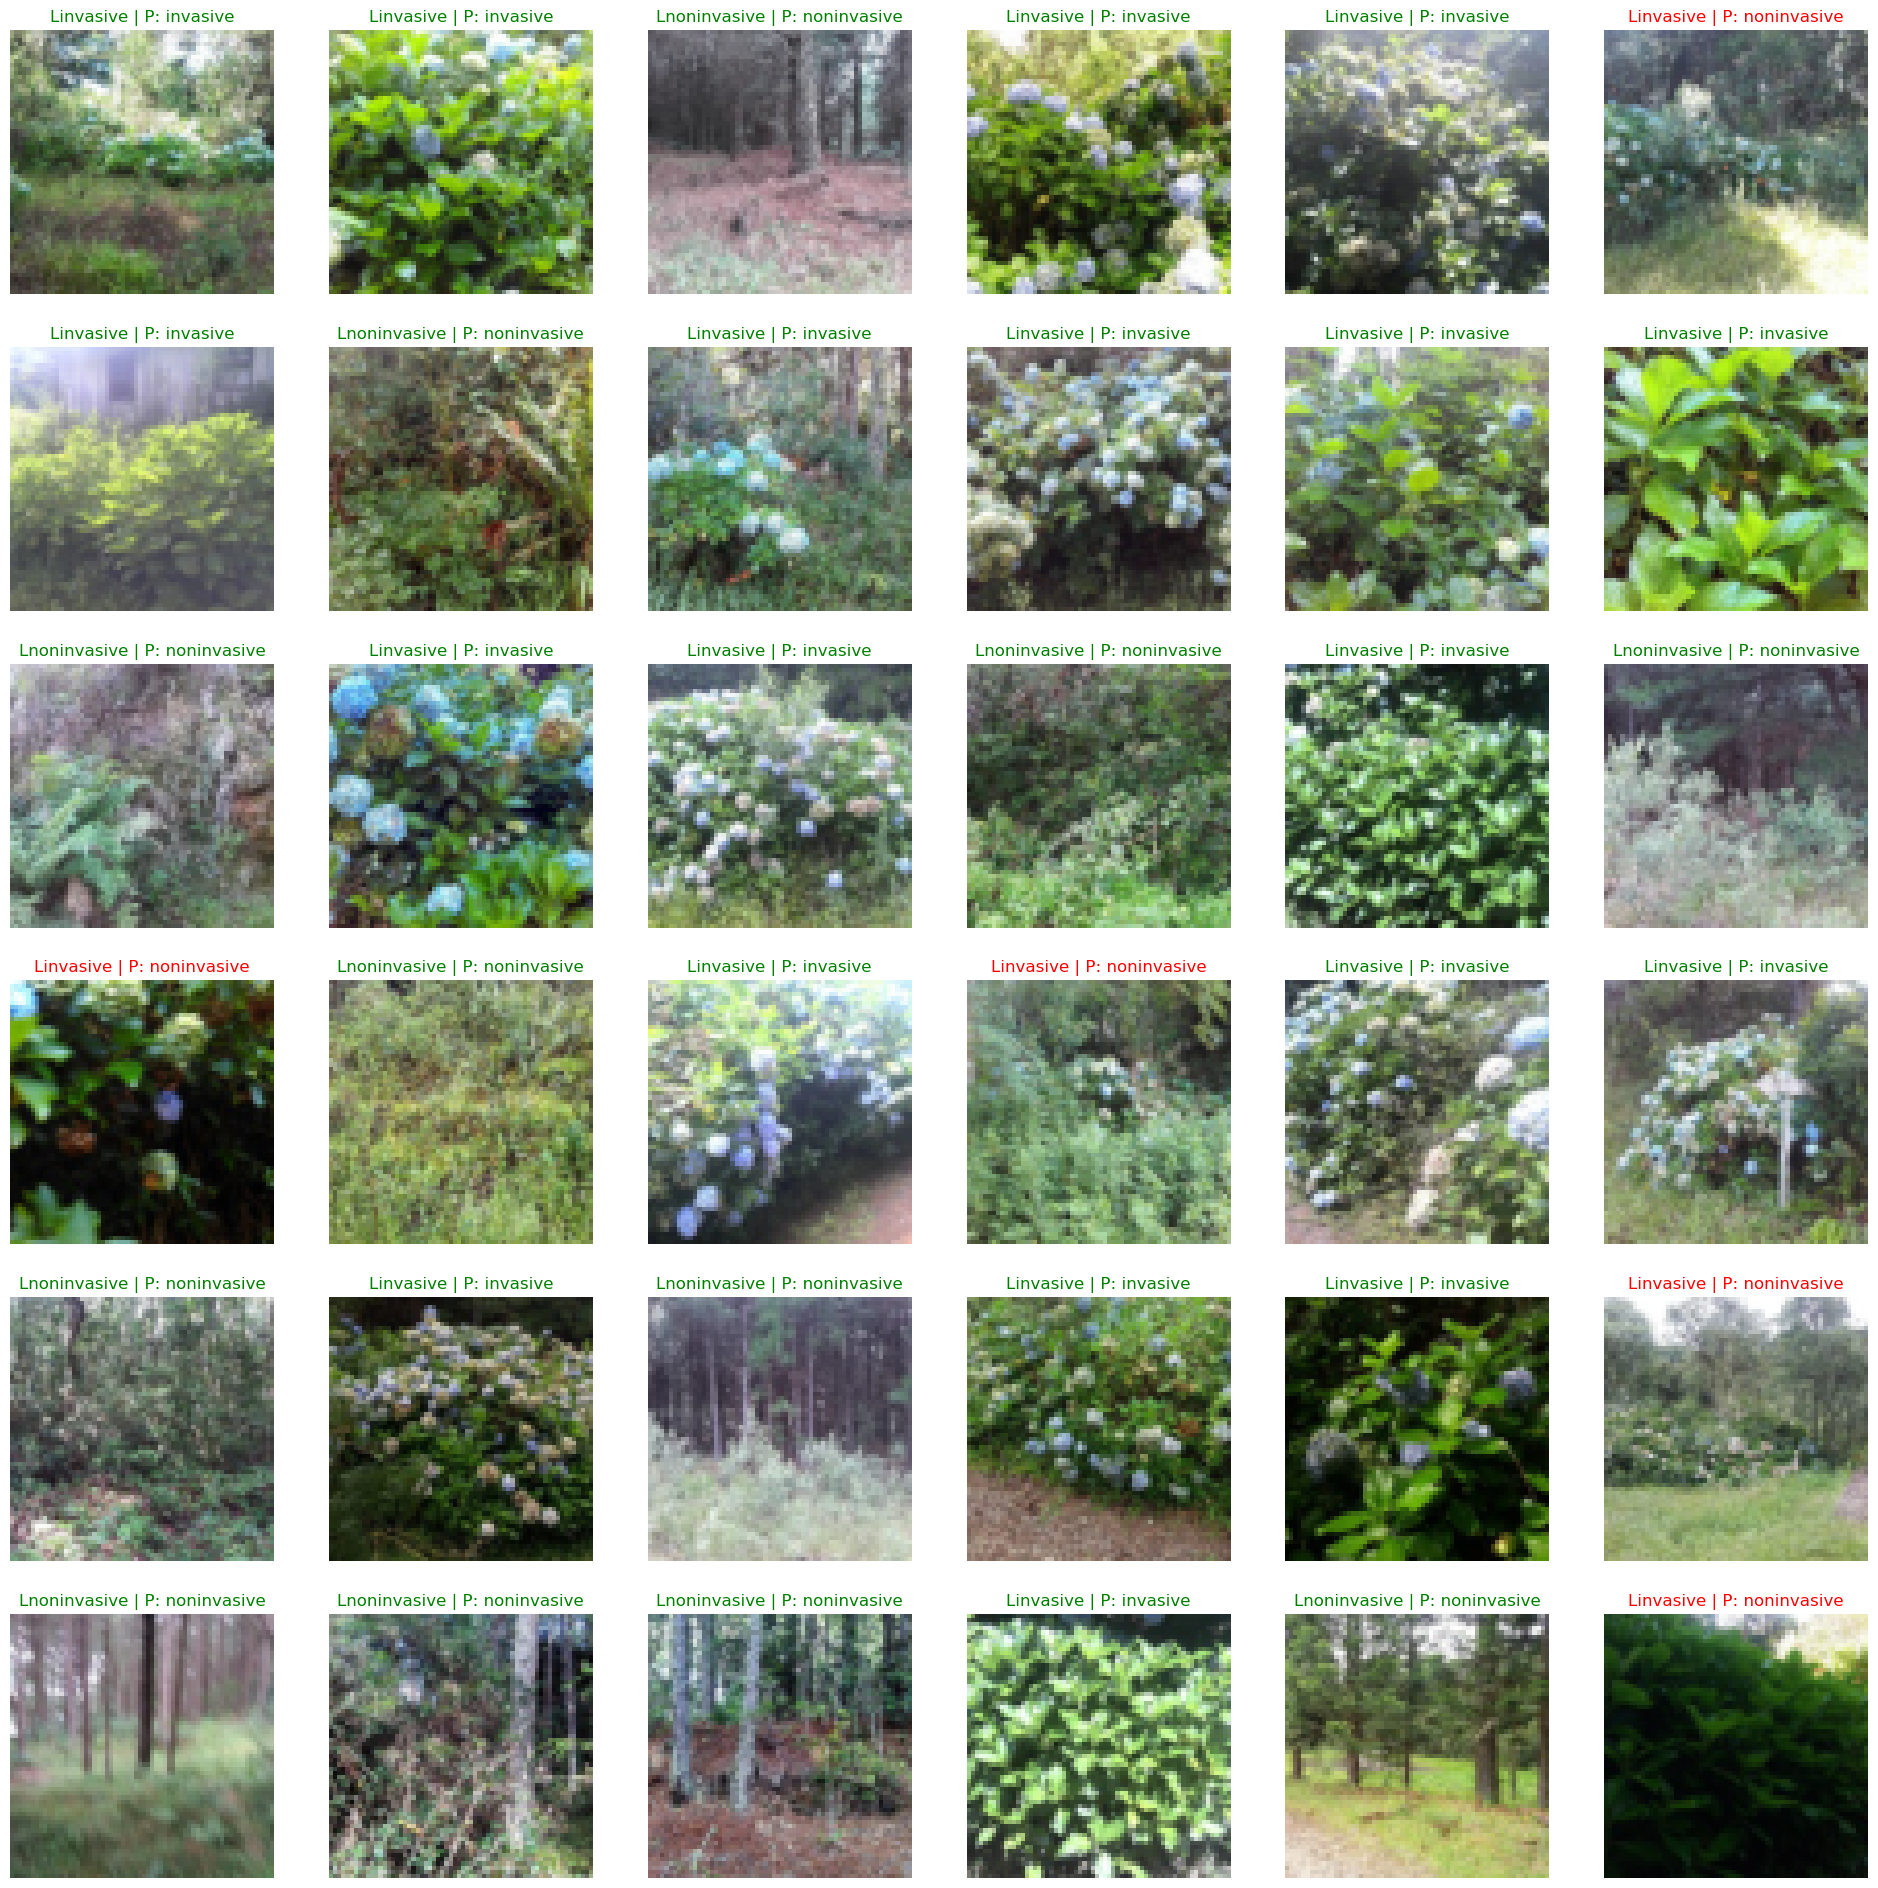

In [27]:
fig, axes = plt.subplots(6, 6, figsize=(24, 24))
for image, label, pred, ax in zip(feature, target, preds, axes.flatten()):
    ax.imshow(image.permute(1, 2, 0).cpu())
    font = {"color": "r"} if label !=pred else {"color": "g"}
    label, pred = label2cat[label.item()], label2cat[pred.item()]
    ax.set_title(f"L{label} | P: {pred}", fontdict=font);
    ax.axis('off');

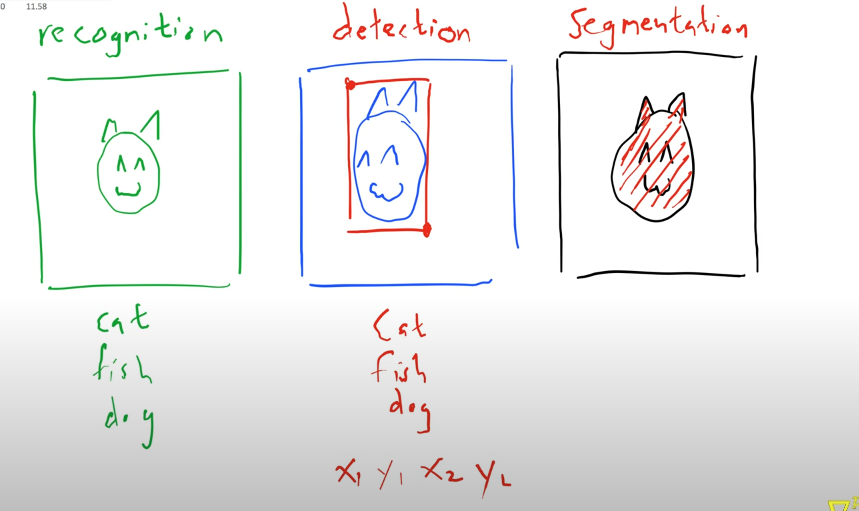